# Proyek Klasifikasi Gambar: [Intel Image Classification]
- **Nama:** Fauzan Andriana Rachman
- **Email:** fauzanrachman05@gmail.com
- **ID Dicoding:** Fauzan Andriana Rachman



## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
from collections import Counter

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory


# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [ ]:
!rm -rf *

In [3]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fauzanandrianar","key":"489811fcbc4b3b0ce2185578f62fdbe9"}'}

In [4]:
# Buat direktori jika belum ada

os.makedirs("/root/.kaggle", exist_ok=True)

# Pindahkan file ke direktori .kaggle

shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Atur permission agar tidak terlalu terbuka

os.chmod("/root/.kaggle/kaggle.json", 600)

In [5]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors


In [6]:
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [7]:

# Path folder asal
source_dirs = ['/content/seg_train/seg_train', '/content/seg_test/seg_test']
# Path folder tujuan
final_dir = '/content/final'

# Buat folder final kalau belum ada
os.makedirs(final_dir, exist_ok=True)

# Gabungkan semua folder
for src_dir in source_dirs:
    for class_name in os.listdir(src_dir):
        src_class_dir = os.path.join(src_dir, class_name)
        dst_class_dir = os.path.join(final_dir, class_name)

        os.makedirs(dst_class_dir, exist_ok=True)

        for filename in os.listdir(src_class_dir):
            src_file = os.path.join(src_class_dir, filename)
            dst_file = os.path.join(dst_class_dir, filename)

            # Hindari overwrite jika file sudah ada
            if not os.path.exists(dst_file):
                shutil.copy2(src_file, dst_file)

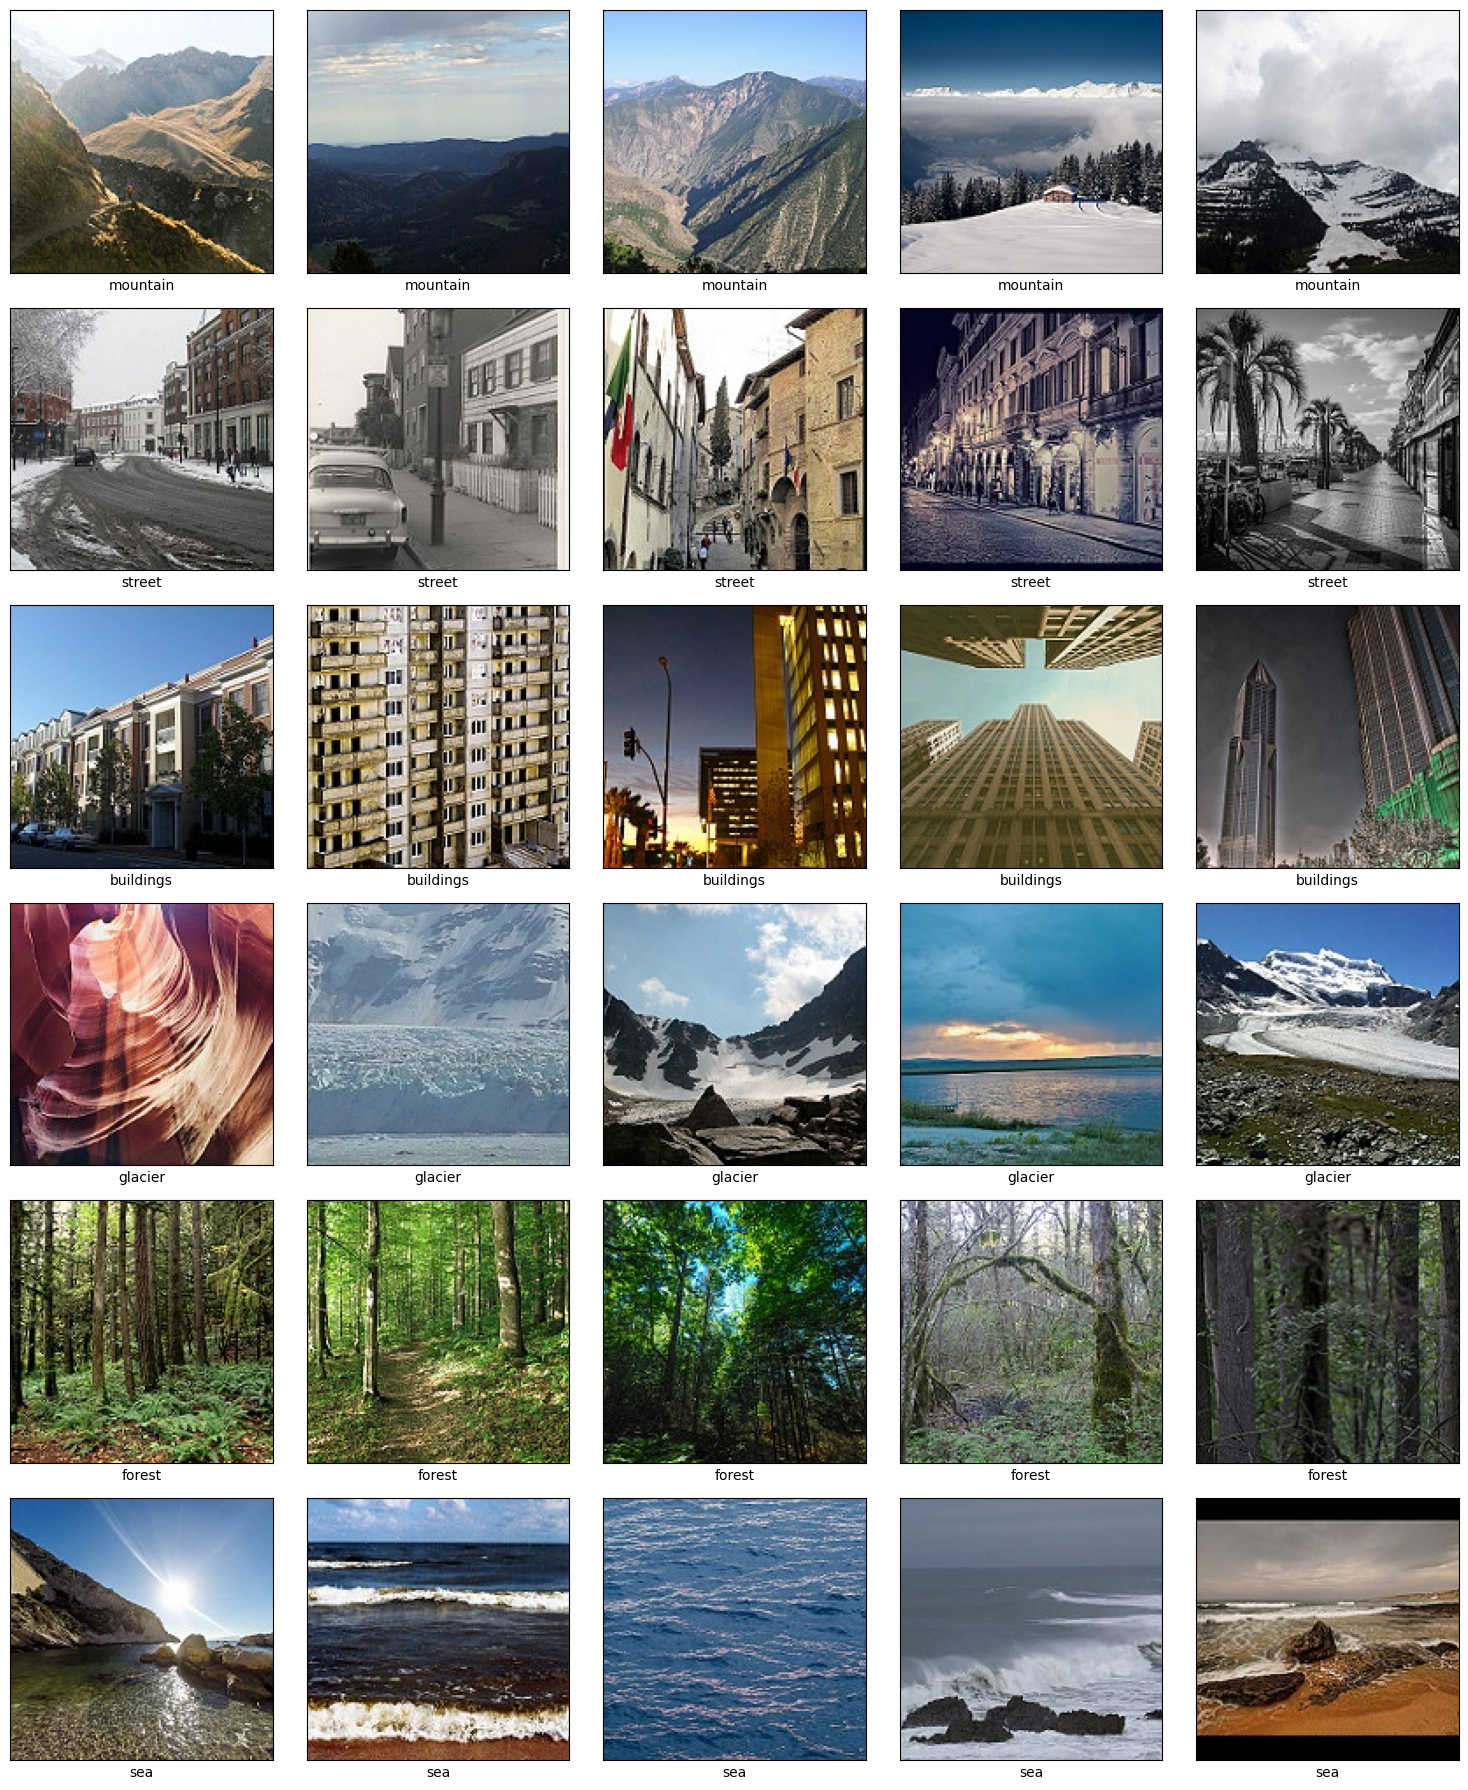

In [8]:

# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path sumber dataset
path = "/content/final"

# Mengisi kamus dengan nama file gambar dari tiap kelas
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    lung_image[class_name] = os.listdir(class_path)

# Menampilkan secara acak 5 gambar dari setiap kelas (6 kelas)
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 18))

for i, class_name in enumerate(lung_image.keys()):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path).convert("RGB")  # Tetap dalam format RGB
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()

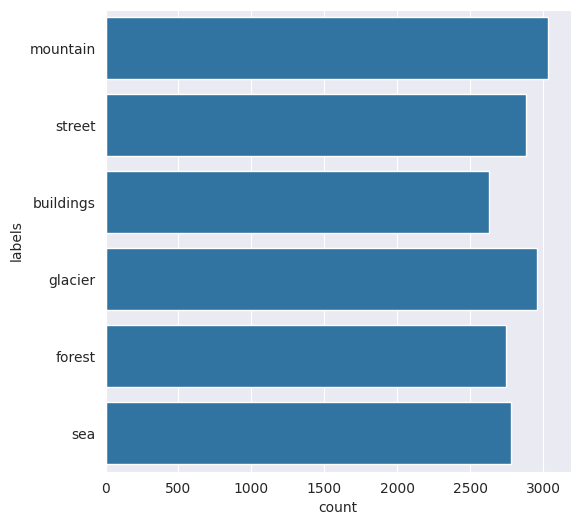

In [9]:
# Define source path
lung_path = "final/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

In [10]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'final/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
buildings    2628
forest       2745
glacier      2957
mountain     3037
sea          2784
street       2883
dtype: int64

In [11]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [12]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [13]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 13627
test size 3407


In [14]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels   
test   buildings     540
       forest        540
       glacier       593
       mountain      612
       sea           576
       street        546
train  buildings    2088
       forest       2205
       glacier      2364
       mountain     2425
       sea          2208
       street       2337
dtype: int64 


                          path    labels    set
4746   final/mountain/3162.jpg  mountain  train
9924     final/forest/6252.jpg    forest  train
4106   final/glacier/20948.jpg   glacier  train
13187       final/sea/2715.jpg       sea  train
7550   final/glacier/21409.jpg   glacier  train


In [15]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "final/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [16]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [32]:

# Normalisasi dan augmentasi sederhana
datagen = ImageDataGenerator(
    rescale=1/255.,
    validation_split=0.2  # untuk validasi dari training set
)

test_datagen = ImageDataGenerator(rescale=1/255.)

# Path direktori dataset yang sudah dipisah
TRAIN_DIR = "Dataset-Final/train"
TEST_DIR = "Dataset-Final/test"

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),  # Sesuaikan ukuran gambar menjadi 224x224
    batch_size=32,
    class_mode='categorical',
    color_mode="rgb",
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),  # Sesuaikan ukuran gambar menjadi 224x224
    batch_size=32,
    class_mode='categorical',
    color_mode="rgb",
    subset='validation',
    shuffle=False
)


# Data Testing
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),  # <- disesuaikan dari 150x150
    batch_size=1,
    class_mode='categorical',
    color_mode="rgb",
    shuffle=False
)


Found 10904 images belonging to 6 classes.
Found 2723 images belonging to 6 classes.
Found 3407 images belonging to 6 classes.


## Modelling

In [25]:

mobilenet_dasar = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
mobilenet_dasar.trainable = False

model_akhir = Sequential([
    mobilenet_dasar,
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    GlobalAveragePooling2D(),
    Dropout(rate=0.5),
    Dense(units=128, activation='relu'),
    Dense(units=6, activation='softmax')
])

model_akhir.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



model_akhir.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,631,654 (10.04 MB)

 Trainable params: 373,670 (1.43 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Evaluasi dan Visualisasi

In [26]:
hentikan_dini = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

kurangi_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

riwayat = model_akhir.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[hentikan_dini, kurangi_lr]
)


Epoch 1/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 44s 92ms/step - accuracy: 0.7094 - loss: 0.7605 - val_accuracy: 0.8931 - val_loss: 0.3352 - learning_rate: 0.0010
Epoch 2/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.8455 - loss: 0.4175 - val_accuracy: 0.9049 - val_loss: 0.3113 - learning_rate: 0.0010
Epoch 3/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.8726 - loss: 0.3311 - val_accuracy: 0.9038 - val_loss: 0.3031 - learning_rate: 0.0010
Epoch 4/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step - accuracy: 0.8831 - loss: 0.3038 - val_accuracy: 0.9141 - val_loss: 0.2634 - learning_rate: 0.0010
Epoch 5/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 22s 66ms/step - accuracy: 0.8923 - loss: 0.2866 - val_accuracy: 0.9075 - val_loss: 0.2779 - learning_rate: 0.0010
Epoch 6/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.9032 - loss: 0.2572 - val_accuracy: 0.9067 - val_loss: 0.3115 - learning_rate: 0.0010
Epoch 7/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.9066 - l

In [44]:
# Evaluasi model terhadap test set
test_loss, test_accuracy = model_akhir.evaluate(test_generator)
print(f"Akurasi pada data test: {test_accuracy:.4f}")
print(f"Loss pada data test: {test_loss:.4f}")


3407/3407 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.9105 - loss: 0.2580
Akurasi pada data test: 0.9169
Loss pada data test: 0.2630


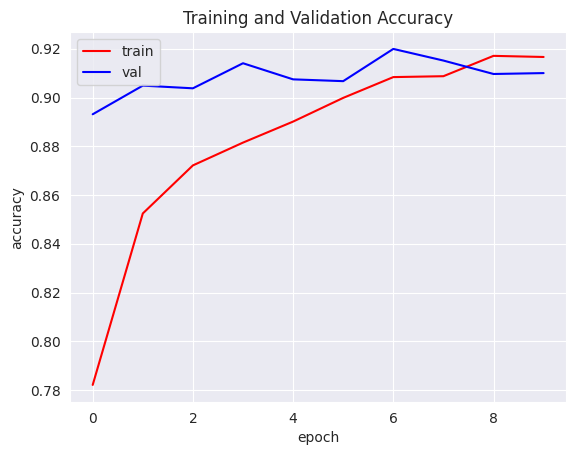

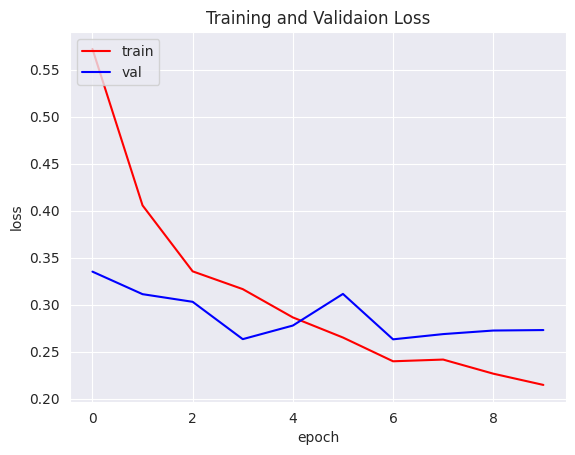

In [27]:
acc = riwayat.history['accuracy']
val_acc = riwayat.history['val_accuracy']
loss = riwayat.history['loss']
val_loss = riwayat.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

3407/3407 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step


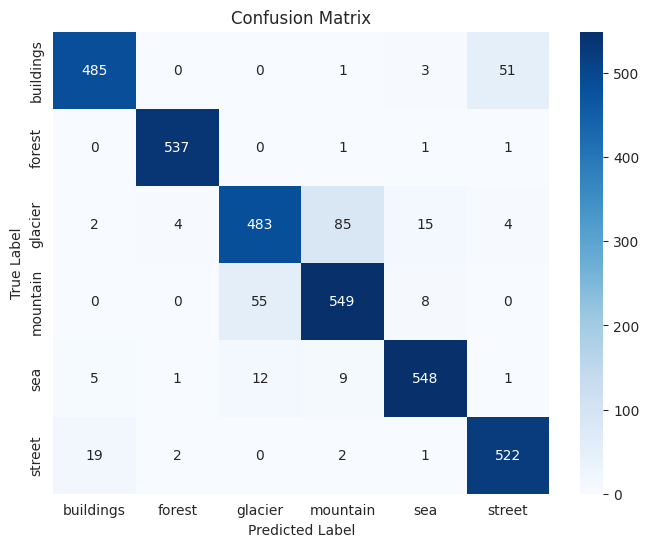

In [33]:

# Lakukan prediksi terhadap test dataset
y_pred_probs = model_akhir.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Ekstrak label asli dari test_generator
y_true = test_generator.classes  # label asli dari test_generator

# Ambil class names dari test_generator
labels = list(test_generator.class_indices.keys())

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [34]:
# Tampilkan classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))

Classification Report:

              precision    recall  f1-score   support

   buildings       0.95      0.90      0.92       540
      forest       0.99      0.99      0.99       540
     glacier       0.88      0.81      0.85       593
    mountain       0.85      0.90      0.87       612
         sea       0.95      0.95      0.95       576
      street       0.90      0.96      0.93       546

    accuracy                           0.92      3407
   macro avg       0.92      0.92      0.92      3407
weighted avg       0.92      0.92      0.92      3407



## Konversi Model

### Export model

In [35]:
# Eksport model ke format SavedModel
model_akhir.export('saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_316')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  136969193414800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136969193416528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136969193416912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136969193416720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136969193414608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136969193418064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136969193418448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136969193418832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136969193418640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136969193415952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136969193419984

### TF lite

In [36]:

saved_model_path = 'saved_model'
tflite_output_path = 'tflite/model.tflite'
label_output_path = 'tflite/label.txt'

# Buat folder output
os.makedirs(os.path.dirname(tflite_output_path), exist_ok=True)

# Konversi model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

# Simpan model
with open(tflite_output_path, 'wb') as f:
    f.write(tflite_model)
print(f"Model TFLite berhasil disimpan di: {tflite_output_path}")

# Ambil class names dari test_generator jika tersedia
try:
    class_names = list(test_generator.class_indices.keys())
except NameError:
    class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
    print("'class_names' tidak ditemukan, menggunakan default label Intel.")

# Simpan label ke file
with open(label_output_path, 'w') as f:
    for label in class_names:
        f.write(label + '\n')
print(f"Label kelas berhasil disimpan di: {label_output_path}")

Model TFLite berhasil disimpan di: tflite/model.tflite
Label kelas berhasil disimpan di: tflite/label.txt


### tfjs

In [37]:
# Install library TensorFlow.js jika belum tersedia
!pip install tensorflowjs

# Konversi model SavedModel ke format TensorFlow.js (Graph Model)
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    saved_model \
    tfjs_model



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-04-23 00:55:34.630946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745369734.663022   12899 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174

In [41]:

# Kompres dan download
# shutil.make_archive('saved_model', 'zip', 'saved_model')
# files.download('saved_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:

# Zip folder tflite
# shutil.make_archive('tflite', 'zip', 'tflite')

# Mengunduh file ZIP
# files.download('tflite.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:

# Zip folder tfjs
# shutil.make_archive('tfjs_model', 'zip', 'tfjs_model')

# Mengunduh file ZIP
# files.download('tfjs_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

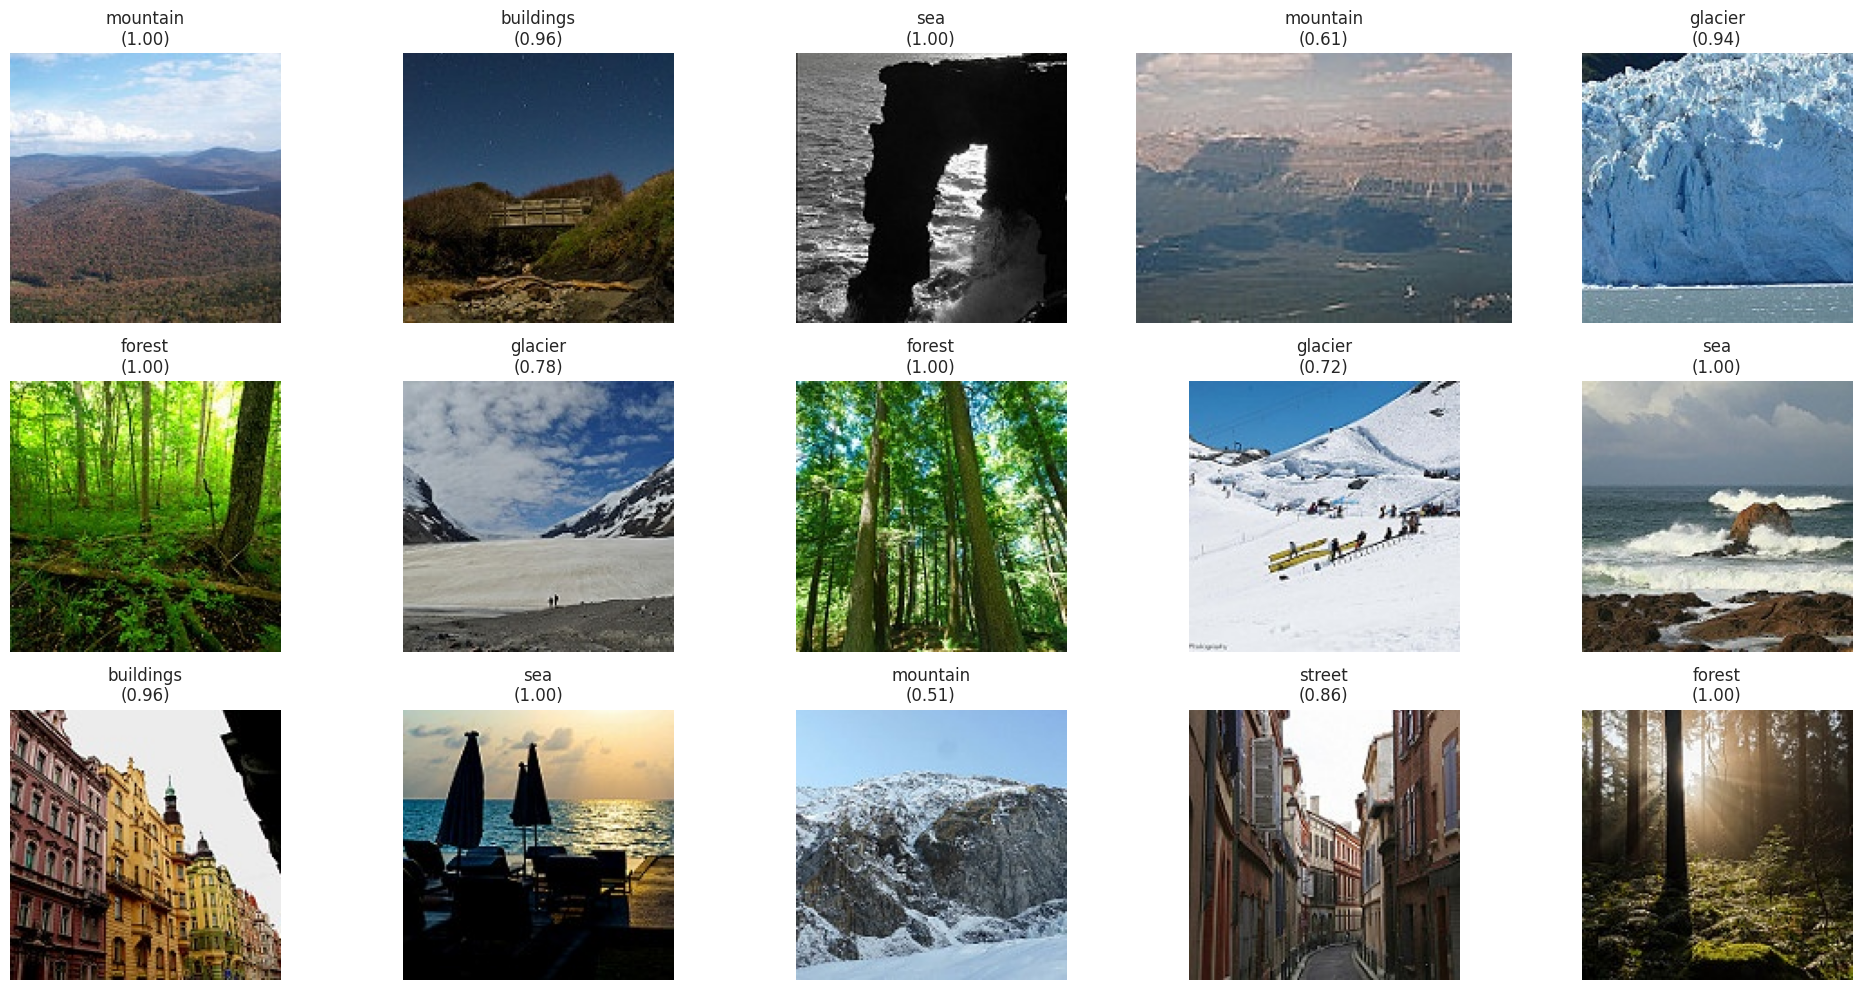

In [38]:

# Path model dan label
model_path = 'tflite/model.tflite'
label_path = 'tflite/label.txt'
image_dir = 'seg_pred/seg_pred/'

# Load label
with open(label_path, 'r') as f:
    class_names = [line.strip() for line in f.readlines()]

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Dapatkan detail input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Ambil ukuran input model
input_shape = input_details[0]['shape']
img_height, img_width = input_shape[1], input_shape[2]

# Fungsi untuk muat & preprocessing gambar
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img_resized = img.resize((img_width, img_height))
    img_array = np.array(img_resized, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img, img_array

# Ambil maksimal 15 gambar
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))][:15]

# Buat plot
plt.figure(figsize=(20, 10))

for i, img_file in enumerate(image_files):
    img_path = os.path.join(image_dir, img_file)
    original_img, input_data = load_and_preprocess_image(img_path)

    # Inference
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    predicted_class = np.argmax(output_data)
    confidence = np.max(output_data)
    label = class_names[predicted_class]

    # Tampilkan
    plt.subplot(3, 5, i+1)
    plt.imshow(original_img)
    plt.title(f"{label}\n({confidence:.2f})")
    plt.axis('off')

plt.tight_layout()
plt.show()